# Single-cell RNA-seq analysis workflow for 1M cells using Scanpy on CPU

Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Import requirements

In [1]:
import time

import numpy as np
import scanpy as sc
from sklearn.cluster import KMeans

import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

## Input data

In [2]:
# Add path to input file here.
input_file = "../data/1M_brain_cells_10X.sparse.h5ad"
USE_FIRST_N_CELLS = 1000000

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/1M_brain_cells_10X.sparse.h5ad',
              input_file)

## Set parameters

In [3]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["Stmn2", "Hes1", "Olig1"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# Batched PCA
pca_train_ratio = 0.35 # percentage of cells to use for PCA training, when using batched PCA function
n_pca_batches = 10 # number of batches, when using batched PCA function

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

# Number of parallel jobs for t-SNE and k-means
n_jobs=32

In [4]:
start = time.time()

## Load and Prepare Data

In [5]:
%%time
adata = sc.read(input_file)
adata.var_names_make_unique()
adata.shape

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: user 1min 34s, sys: 5.29 s, total: 1min 40s
Wall time: 1min 39s


(1306127, 27998)

In [6]:
adata = adata[0:USE_FIRST_N_CELLS]
adata.shape

(1000000, 27998)

## Preprocessing

In [7]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [8]:
%%time
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)

Trying to set attribute `.obs` of view, copying.


CPU times: user 2min 8s, sys: 39.8 s, total: 2min 48s
Wall time: 2min 48s


Some genes will now have zero expression in all cells. We filter out such genes.

In [9]:
%%time
sc.pp.filter_genes(adata, min_cells=1)

CPU times: user 27.8 s, sys: 8.76 s, total: 36.5 s
Wall time: 36.5 s


In [10]:
adata.shape

(989838, 23781)

### Normalize

In [11]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 9.04 s, sys: 1.12 s, total: 10.2 s
Wall time: 10.1 s


In [12]:
%%time
sc.pp.log1p(adata)

CPU times: user 35.6 s, sys: 1.16 ms, total: 35.6 s
Wall time: 35.6 s


### Select Most Variable Genes

In [13]:
%%time

# Select highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor = "cell_ranger")

# Retain marker gene expression
for marker in markers:
    adata.obs[marker + "_raw"] = adata.X[:, adata.var.index == marker].todense()

# Filter matrix to only variable genes
adata = adata[:, adata.var.highly_variable]

CPU times: user 32.7 s, sys: 149 ms, total: 32.9 s
Wall time: 32.9 s


### Regress out confounding factors (number of counts, mitochondrial gene expression)

In [14]:
%%time
mito_genes = adata.var_names.str.startswith(MITO_GENE_PREFIX)
n_counts = np.array(adata.X.sum(axis=1))
adata.obs['percent_mito'] = np.array(np.sum(adata[:, mito_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

Trying to set attribute `.obs` of view, copying.


CPU times: user 19.8 s, sys: 705 ms, total: 20.5 s
Wall time: 20.5 s


In [15]:
%%time
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

CPU times: user 6h 32min 40s, sys: 1d 56min 15s, total: 1d 7h 28min 56s
Wall time: 1h 6min 36s


### Scale

In [16]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 34.3 s, sys: 1.74 s, total: 36 s
Wall time: 36 s


In [17]:
preprocess_time = time.time()
print("Total Preprocess time : %s" % (preprocess_time-preprocess_start))

Total Preprocess time : 4337.18128156662


## Cluster & Visualize

### Reduce

First, we calculate the time taken to run PCA using the complete dataset.

In [18]:
%%time
sc.tl.pca(adata, n_comps=n_components)

CPU times: user 1h 9min 28s, sys: 21min 8s, total: 1h 30min 36s
Wall time: 2min 17s


For a fair comparison with the single-GPU notebook, we also calculate the time taken if we use the PCA function from `utils.py`, which uses only a fraction of the cells for training.

In [19]:
%%time
adata = utils.pca(adata, n_components=n_components, 
                  train_ratio=pca_train_ratio, 
                  n_batches=n_pca_batches, gpu=False)

CPU times: user 7min 35s, sys: 4min 36s, total: 12min 12s
Wall time: 28.5 s


### TSNE + K-means

In [20]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs, n_jobs=n_jobs)

CPU times: user 9h 9min 5s, sys: 17min 6s, total: 9h 26min 12s
Wall time: 1h 37min 13s


In [21]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=n_jobs).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 44min 40s, sys: 19min 20s, total: 1h 4min 1s
Wall time: 1min 53s


... storing 'kmeans' as categorical


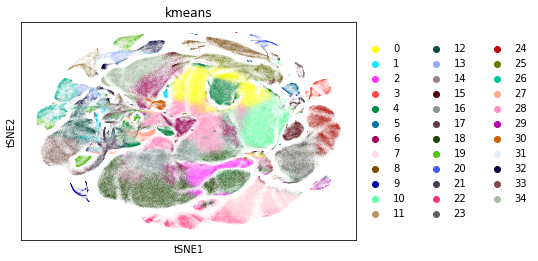

CPU times: user 9.03 s, sys: 0 ns, total: 9.03 s
Wall time: 9.03 s


In [22]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

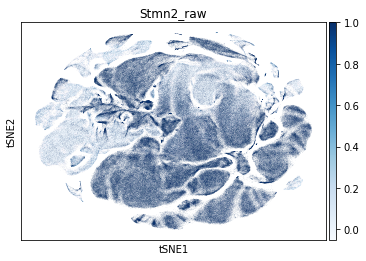

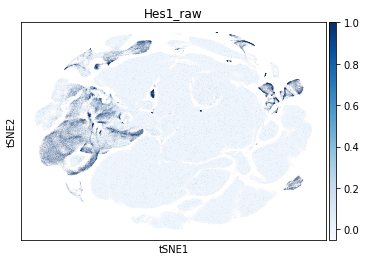

CPU times: user 7.83 s, sys: 0 ns, total: 7.83 s
Wall time: 7.82 s


In [23]:
%%time
sc.pl.tsne(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

### UMAP + Graph clustering

In [24]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 10min 27s, sys: 46.4 s, total: 11min 13s
Wall time: 11min 10s


In [25]:
%%time
# UMAP
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 5h 41min 39s, sys: 2h 1s, total: 7h 41min 41s
Wall time: 23min 25s


In [26]:
%%time
# Louvain clustering
sc.tl.louvain(adata)

CPU times: user 9min 31s, sys: 2.4 s, total: 9min 34s
Wall time: 9min 33s


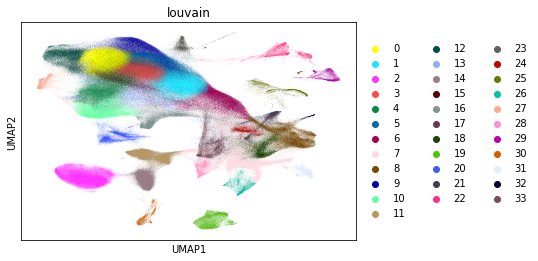

CPU times: user 6.91 s, sys: 631 ms, total: 7.54 s
Wall time: 7.54 s


In [27]:
%%time
sc.pl.umap(adata, color=["louvain"])

In [28]:
%%time
# Leiden clustering
sc.tl.leiden(adata)

CPU times: user 1h 46min 56s, sys: 9.71 s, total: 1h 47min 6s
Wall time: 1h 46min 54s


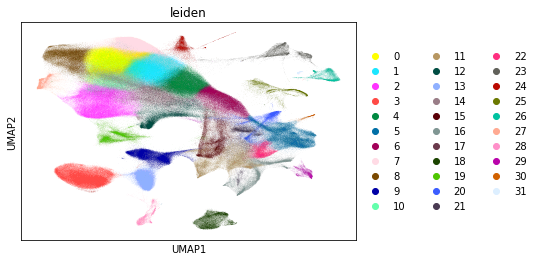

CPU times: user 7.01 s, sys: 691 ms, total: 7.71 s
Wall time: 7.7 s


In [29]:
%%time
sc.pl.umap(adata, color=["leiden"])

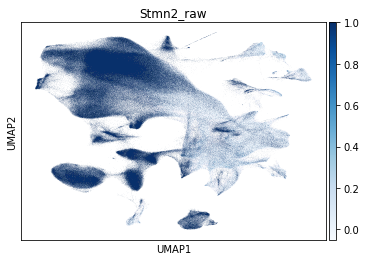

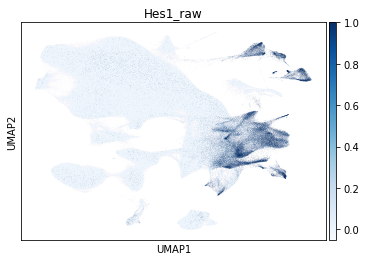

CPU times: user 7.86 s, sys: 0 ns, total: 7.86 s
Wall time: 7.86 s


In [30]:
%%time
sc.pl.umap(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

## Create zoomed-in view

In [31]:
reanalysis_start = time.time()

In [32]:
%%time
adata = adata[adata.obs["Hes1_raw"] > 0.0, :]
print(adata.X.shape)

(95916, 4000)
CPU times: user 2.92 s, sys: 185 ms, total: 3.11 s
Wall time: 3.11 s


In [33]:
%%time
sc.tl.pca(adata, n_comps=n_components)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)
sc.tl.leiden(adata)

CPU times: user 26min 19s, sys: 18min 2s, total: 44min 21s
Wall time: 4min 9s


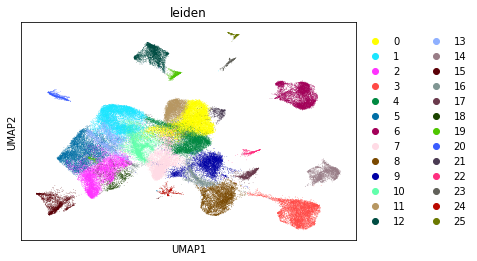

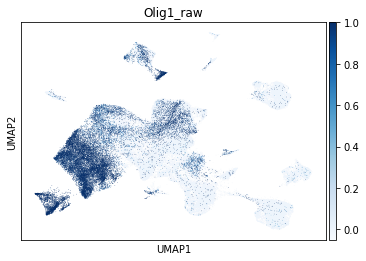

CPU times: user 889 ms, sys: 1.01 s, total: 1.89 s
Wall time: 1.89 s


In [34]:
%%time
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color=["Olig1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [35]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 254.8757574558258


In [36]:
print("Full time: %s" % (time.time() - start))

Full time: 19907.544170856476
